# TP sur le topic modeling

François HU - Data scientist au DataLab de la Société Générale Assurances - *05/07/21*

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Introduction

Les topic models (*modèles thématiques* en français) sont une famille de modèles qui sont capables de découvrir les topics (*thèmes* en français) d'une collection de documents textuels. Dans ce contexte, le terme "**topic**" désigne des groupes de mots qui se retrouvent souvent ensemble dans un même document. Par exemple, dans un recueil d'articles de journaux, un topic model peut identifier un topic composé des mots :
- "homme politique", "droit" et "parlement", et un autre caractérisé par 
- "joueur", "match" et "carton rouge"

Les topics modeling ne peuvent pas affecter un titre à ces topics : c'est notre tâche d'interpréter ces topics et de leur donner des étiquettes telles que **politique** et **football**.

La particularité de ces méthodes c'est que nous n'avons pas de labels : ce sont des tâches **non-supervisées**.

L'un des modèles les plus populaires est le LDA. Le LDA est un modèle génératif qui considère chaque document comme un mélange de topics. Ce sont ces topics qui seront en charge de générer les mots. Par exemple, 

- le topic **football** générera le mot "ballon" avec une probabilité élevée, 
- tandis que le topic **politique** aura une probabilité beaucoup plus élevée pour générer le mot "politicien" que pour générer le mot "ballon"

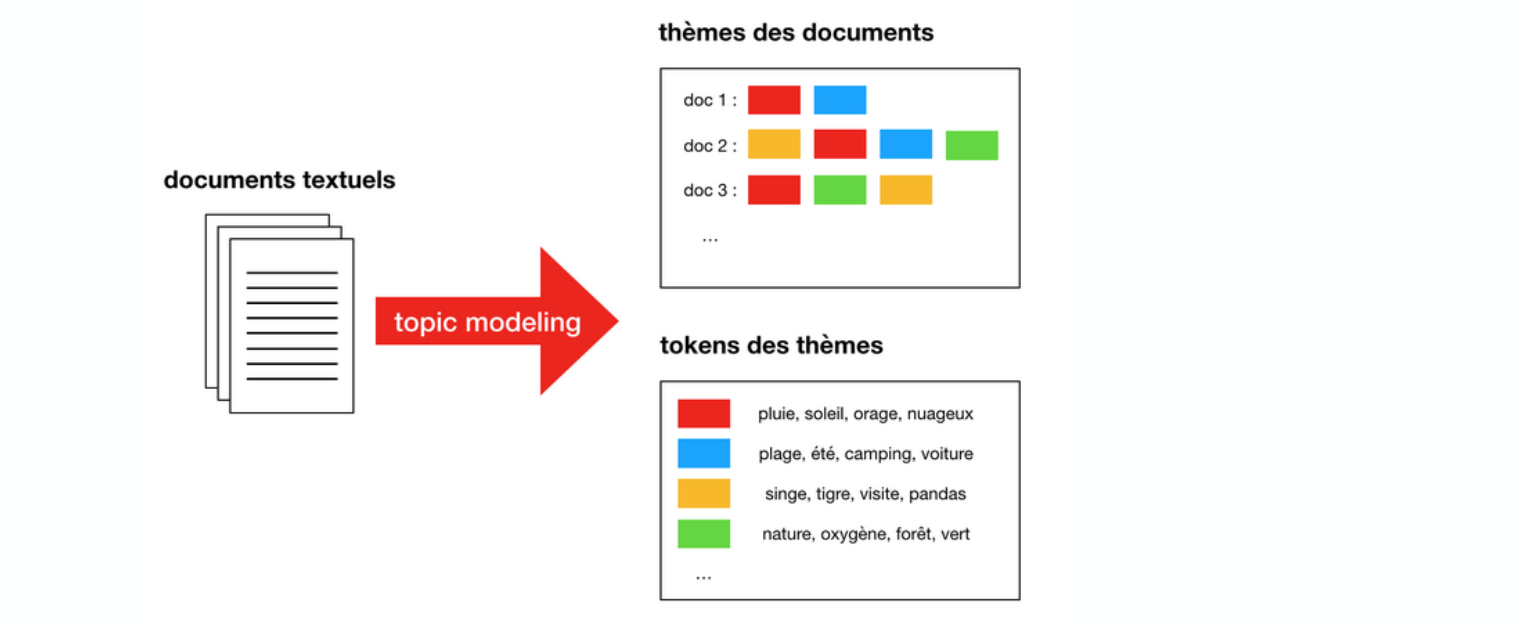

## Données : Grand Débat National

- L'un des contextes où la modélisation des topics est très utile est celui des questions ouvertes. Il nous permet d'explorer les différents topics abordés dans les réponses des gens. 

- Dans ce notebook nous allons explorer un ensemble complet de réponses du [Grand Débat National](https://granddebat.fr/), un débat public organisé par le président Macron. Le but du débat était de mieux comprendre les besoins et les opinions des Français suite aux manifestations des gilets jaunes. Les résultats de ce débat sont maintenant disponibles sous forme de [données ouvertes](https://granddebat.fr/pages/donnees-ouvertes).

## 2. Charger les données

Nous allons tout d'abord importer un des fichiers csv sur la transition écologique dans un dataframe [pandas](https://pandas.pydata.org/).

In [2]:
%%capture captured

import pandas as pd

chemin = ... # TODO

raw_data = pd.read_csv(chemin, error_bad_lines=False, warn_bad_lines=False)

Chacune des lignes de ce dataframe ``raw_data`` contient des réponses répondant à une liste de questions sur la transition écologique. Certaines de ces questions sont à choix multiples, tandis que d'autres sont des questions ouvertes. 

In [3]:
raw_data.columns

Index(['reference', 'title', 'createdAt', 'publishedAt', 'updatedAt',
       'trashed', 'trashedStatus', 'authorId', 'authorType', 'authorZipCode',
       'Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?',
       'Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?',
       'Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?',
       'Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?',
       'À titre personnel, pensez-vous pouvoir contribuer à protéger l'environnement ?',
       'Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?',
       'Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?',
   

Nous allons étudier la dernière question : 

``Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?`` 

car cette dernière laisse plus de liberté aux personnes. Notre objectif est d'analyser les topics sur lesquels portent leurs réponses grâce au modèle LDA.

In [4]:
question = "Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?"
data = raw_data[question]

In [5]:
data.head()

0               Multiplier les centrales géothermiques
1    Les problèmes auxquels se trouve confronté l’e...
2                                                  NaN
3                                                  NaN
4      Une vrai politique écologique et non économique
Name: Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?, dtype: object

Nous pouvons remarquer qu'il y a beaucoup de données manquantes (comme toute question ouverte, les personnes décident oui ou non d'écrire un commentaire). Une étape de néttoyage est donc nécessaire.

## 3. Nettoyer et vectoriser les documents

Avant d'entraîner notre modèle LDA, nous avons besoin de tokenizer notre texte. Nous allons tokenizer grâce à la librarie [spaCy](https://spacy.io/) car nous allons effectuer seulement quelques prétraitements de base. Nous allons juste initialiser un modèle vierge pour la langue française.

**Remarques :** Après avoir installé la librairie SpaCy (pip install spacy), il faut télécharger un pipeline entraîné pour la langue française.

``python -m spacy download fr_core_news_sm``

spaCy fournit une variété d'annotations linguistiques pour vous donner un aperçu de la structure grammaticale d'un texte. Cela inclut entre autres des preprocessing classique en NLP à savoir la **lemmatisation**.

In [6]:
import spacy

nlp = spacy.load("fr_core_news_sm")

Supprimons toutes les lignes du dataframe qui n'ont pas de réponse pour notre question (les `NaN`s ci-dessus). Ce nouveau dataframe s'appellera ``textes``

In [7]:
... # TODO

In [8]:
textes.head()

0               Multiplier les centrales géothermiques
1    Les problèmes auxquels se trouve confronté l’e...
4      Une vrai politique écologique et non économique
5    Les bonnes idées ne grandissent que par le par...
6    Pédagogie dans ce sens là dés la petite école ...
Name: Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?, dtype: object

Ensuite, nous utilisons spaCy pour effectuer notre premier prétraitement (cela peut prendre quelques minutes) :

In [9]:
%%time

spacy_docs = list(nlp.pipe(textes))

CPU times: user 3min 33s, sys: 42.2 s, total: 4min 16s
Wall time: 4min 25s


Nous avons maintenant une liste de documents spaCy. Nous allons transformer chaque document spaCy en une liste de tokens. Au lieu des tokens originaux, nous allons travailler avec les lemmes à la place. Cela permettra à notre modèle de mieux généraliser. En effet, nous voulons par exemple que "continuation" et "continuations" représentent la même signification. Voici la liste complète des prétraitements : 
 
1. supprimer tous les **mots de moins de 3 caractères**,
2. supprimer tous les **stop-words**, et
3. **lemmatiser** les mots restants et,
4. mettre ces mots en **minuscules**.

In [10]:
%%time

docs = []
for doc in spacy_docs:
    tokens = []
    for token in doc:
        if len(token.orth_) > 3 and not token.is_stop: # prétraitements 1 et 2
            ... # TODO: prétraitements 3 et 4
    docs.append( tokens )

CPU times: user 1.55 s, sys: 155 ms, total: 1.71 s
Wall time: 1.72 s


Voici un aperçu du **premier** document tokenisé :

In [11]:
print(docs[0])

['multiplier', 'centrale', 'géothermique']


**deuxième** document tokenisé :

In [12]:
print(docs[1])

['problème', 'trouve', 'confronter', 'ensemble', 'planète', 'dénoncent', 'parfaire', 'désordre', 'gilet', 'jaune', 'france', 'il', 'surpopulation', 'mondial', 'population', 'passer', 'd’1,5', 'milliard', 'habitant', '1900', 'milliard', '2020', 'monter', 'bientôt', 'milliard', '2040', 'progrès', 'communication', 'village', 'mondial', 'individu', 'fondre', 'asie', 'fondre', 'afrique', 'passer', 'quartiers', 'campagne', 'pays', 'aspir', 'vivr', 'blâmer', 'lotir', 'concitoyen', 'logement', 'nourriture', 'bien', 'consommation', 'déplacement', 'etc.', 'mère', 'problème', 'bien', 'solution', 'problème', 'stabilisation', 'croissance', 'démographique', 'partage', 'richesse', 'partage', 'terre', 'partage', 'protection', 'biodiversité', 'règlement', 'conflit', 'lutte', 'contre', 'déforestation', 'lutte', 'contre', 'dérèglement', 'climatique', 'règlement', 'conflit', 'stabilisation', 'migration', 'concurrence', 'commercial', 'mondial', 'etc.', 'français', 'européen', 'mondial', 'france', 'jouer', 

Afin de conserver un peu l'ordre des mots lors de notre modélisation, nous allons tenir en compte les **bigrammes fréquents**. Pour cela, nous allons utiliser la bibliothèque [Gensim](https://radimrehurek.com/gensim/) (excellente bibliothèque NLP pour les topics modeling et word embeddings)

Voici le processus retenu : 

- **Identifier les bigrammes fréquents** dans le corpus, 
- **Ajouter à la liste des tokens** pour les documents dans lesquels ils apparaissent. 

Cela signifie que les bigrammes ne seront pas dans leur position correcte dans le texte, mais comme les topic models sont des modèles de **bag-of-words** (*sac-de-mots* en français) qui ignorent la position des mots, cela ne pose pas de problèmes.

In [13]:
import re
from gensim.models import Phrases

bigram = Phrases(docs, min_count=10)

for index in range(len(docs)):
    for token in bigram[docs[index]]:
        if '_' in token:  # les bigrammes peuvent être reconnus par "_" qui concatène les mots
            ... # TODO

/Users/Faugon/opt/anaconda3/envs/dsa_nlp/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [22]:
print(docs[4])

['pédagogie', 'sens', 'petit', 'école', 'sensibilisation', 'parc', 'naturel', 'enfant', 'devenir', 'prescripteur', 'génération', 'futur', 'urgence', 'génération_futur']


Passons à la dernière étape du prétraitement spécifique à Gensim. Nous allons tout d'abord créer une représentation dictionnaire des documents. Ce dictionnaire mappera chaque mot à un identifiant unique et nous aidera à créer des représentations en sac-de-mot de chaque document. Ces représentations en sac-de-mots contiennent les identificateurs des mots du document ainsi que leur fréquence (ici en nombre d'occurences). De plus, nous pouvons supprimer les mots les moins fréquents et les plus fréquents du vocabulaire. Cela améliorera la qualité de notre modèle et accélèrera son entraînement.

In [15]:
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)
print('Nombre de mots unique dans les documents initiaux :', len(dictionary))

dictionary.filter_extremes(no_below=3, no_above=0.25)
print('Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents :', len(dictionary))

print("Exemple :", dictionary.doc2bow(docs[4]))

Nombre de mots unique dans les documents initiaux : 33319
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 12869
Exemple : [(170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 1), (182, 1)]


Ensuite, nous créons des représentations en Bag-of-Words pour chaque document du corpus voir la méthode [doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html) :

In [16]:
corpus = ... # TODO

## 4. Topic Modeling avec LDA

Maintenant, il est temps d'entraîner notre LDA ! Pour ce faire, nous utilisons les paramètres suivants : 

- **corpus** : les représentations en sac-de-mots de nos documents
- **id2token** : le mappage des index aux mots
- **num_topics** : le nombre de topics que le modèle doit identifier (fixons à <font color = "red"><b>10</b></font>)
- **chunksize** : le nombre de documents que le modèle voit à chaque mise à jour (fixons à <font color = "red"><b>1 000</b></font>)
- **passes** : le nombre de fois où nous montrons le corpus total au modèle pendant l'entraînement (fixons à <font color = "red"><b>5</b></font>)
- **random_state** : nous utilisons une graine pour assurer la reproductibilité (fixons à <font color = "red"><b>1</b></font>)

Remarquons que l'entraînement peut durer quelques minutes

In [17]:
%%time
from gensim.models import LdaModel

model = ... # TODO

CPU times: user 38.6 s, sys: 216 ms, total: 38.9 s
Wall time: 38 s


## 5. Résultats et visualisation

Voyons ce que le modèle a appris. Pour ce faire, affichons les dix mots les plus caractéristiques pour chacun des topics. Nous obeservons déjà des tendances intéressantes : si certains topics sont plus généraux (comme le topic 3), d'autres font référence à des topics très pertinents : 
- véhicules électriques (**topic 1**), 
- énergie (alternative) (**topic 2**), 
- agriculture (**topic 6**), 
- déchets et recyclage (**topic 7**) et 
- fiscalité (**topic 9**).

In [18]:
for (topic, words) in model.print_topics():
    print("***********")
    print("* topic", topic+1, "*")
    print("***********")
    print(topic+1, ":", words)
    print()

***********
* topic 1 *
***********
1 : 0.041*"produit" + 0.035*"agriculture" + 0.023*"pesticide" + 0.022*"environnement" + 0.018*"interdir" + 0.017*"agriculteur" + 0.016*"animal" + 0.015*"santé" + 0.015*"industriel" + 0.014*"chasse"

***********
* topic 2 *
***********
2 : 0.043*"terme" + 0.027*"long" + 0.022*"logement" + 0.017*"bâtiment" + 0.017*"mode" + 0.015*"construction" + 0.015*"court" + 0.014*"long_terme" + 0.011*"chauffage" + 0.011*"public"

***********
* topic 3 *
***********
3 : 0.021*"falloir" + 0.017*"faire" + 0.012*"bien" + 0.012*"france" + 0.010*"pays" + 0.010*"planète" + 0.009*"problème" + 0.008*"être" + 0.008*"politique" + 0.008*"monde"

***********
* topic 4 *
***********
4 : 0.070*"énergie" + 0.042*"nucléaire" + 0.019*"renouvelable" + 0.017*"éolien" + 0.017*"développer" + 0.014*"centrale" + 0.013*"production" + 0.012*"fossile" + 0.012*"recherche" + 0.012*"falloir"

***********
* topic 5 *
***********
5 : 0.010*"public" + 0.010*"investissement" + 0.009*"pouvoir" + 0.0

Une autre façon d'observer les topics est de les **visualiser**. Ceci peut être fait avec la bibliothèque [pyLDAvis](https://github.com/bmabey/pyLDAvis). PyLDAvis nous illustre :

- à quel point les sujets sont **populaires** dans notre corpus, 
- à quel point les sujets sont **similaires**
- et quels sont les **mots les plus importants** pour ce sujet. 

Notez que cela peut prendre quelques minutes pour charger.

In [19]:
import pyLDAvis.gensim_models
import warnings

pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning) 

pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)

/Users/Faugon/opt/anaconda3/envs/dsa_nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/Faugon/opt/anaconda3/envs/dsa_nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Faugon/opt/anaconda3/envs/dsa_nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/Faugon/opt/anaconda3/envs/dsa_nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.336377 -0.035428       1        1   5.723847
1     -0.108411  0.278279       2        1   3.894784
2     -0.155007 -0.149856       3        1  16.259059
3     -0.043820  0.143454       4        1   9.113975
4     -0.122107 -0.080526       5        1  17.173217
5     -0.147990 -0.196883       6        1  10.621751
6      0.164253 -0.028587       7        1  11.626945
7      0.063938 -0.067548       8        1   9.463941
8      0.039968 -0.016125       9        1   8.444670
9     -0.027200  0.153220      10        1   7.677812, topic_info=           Term         Freq        Total Category  logprob  loglift
256     énergie  5072.000000  5072.000000  Default  30.0000  30.0000
88   écologique  6136.000000  6136.000000  Default  29.0000  29.0000
466  transition  4761.000000  4761.000000  Default  28.0000  28.0000
252   transport  3425.000000  3425.000000  Default  27.0000  27.0000
167  électrique  3118.000000  3118.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
355   thermique   214.471811   347.079696  Topic10  -5.6185   2.0855
568     vouloir   279.554187  1290.288484  Topic10  -5.3534   1.0374
184       faire   314.006109  6845.291812  Topic10  -5.2372  -0.5151
39       france   273.045335  3668.796888  Topic10  -5.3770  -0.0311
670     arrêter   261.890143  2303.166047  Topic10  -5.4187   0.3927

[666 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9816      4  0.989912   \n\n  
3786      5  0.994599   \n    
8902      5  0.995374  \n     
6944      9  0.991927     2022
6532      9  0.988880     4000
...     ...       ...      ...
1404      6  0.130633     être
1404      7  0.029738     être
1404      9  0.107268     être
1404     10  0.024427     être
642       5  0.994964    œuvre

[1476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Enfin, examinons les topics que le modèle reconnaît dans certains des documents individuels. Nous voyons ici comment LDA tend à attribuer une probabilité élevée à un faible nombre de sujets pour chaque document, ce qui rend ses résultats très interprétables.

In [20]:
# Nous en affichons que 4
n_doc = 4
i = 0
for (text, doc) in zip(textes[:n_doc], docs[:n_doc]):
    i += 1
    print("***********")
    print("* doc", i, "  *")
    print("***********")
    print(text)
    print([(topic+1, prob) for (topic, prob) in model[dictionary.doc2bow(doc)] if prob > 0.1])
    print()

***********
* doc 1   *
***********
Multiplier les centrales géothermiques
[(4, 0.77492505)]

***********
* doc 2   *
***********
Les problèmes auxquels se trouve confronté l’ensemble de la planète et que dénoncent, dans le plus parfait désordre, les gilets jaunes de France ne sont-ils pas dus, avant tout, à la surpopulation mondiale ? Cette population est passée d’1,5 milliards d’habitants en 1900 à 7 milliards en 2020 et montera bientôt à 10 milliards vers 2040.  Avec les progrès de la communication dans ce village mondial, chaque individu, du fin fond de l’Asie au fin fond de l’Afrique, en passant par les « quartiers » et les « campagnes » de notre pays, aspire à vivre – et on ne peu l’en blâmer – comme les moins mal lotis de nos concitoyens (logement, nourriture, biens de consommation, déplacement,etc.).  Voilà la mère de tous les problèmes. Si tel est bien le cas, la solution à tous les problèmes (stabilisation de la croissance démographique, partage des richesses, partage des ter

**Conclusion**

De nombreuses collections de textes non structurés ne sont pas accompagnées de labels. Les topic models (*modèles thématiques* en français) tels que le LDA sont une technique utile pour découvrir les topics les plus importants dans ces documents. **Gensim** facilite l'apprentissage sur ces sujets et **pyLDAvis** présente les résultats d'une manière visuellement attrayante. Ensemble, ils forment une puissante boîte à outils pour mieux comprendre et explorer des sous-ensembles de textes connexes. Si ces résultats sont souvent déjà très révélateurs, il est également possible de les utiliser comme point de départ, par exemple pour un exercice de labellisation pour la classification supervisée de textes. En somme, les modèles thématiques devraient figurer dans la boîte à outils de chaque data scientist comme un moyen très rapide d'obtenir un aperçu des grandes collections de documents.